<div style="text-align:center"><span style="color:purple; font-family:helvetica; font-size:2.0em;">Bipedal Locomotion Control based on Divergent Component of Motion(DCM)</span></div>

<div style="text-align:center">
    <span style="font-family:helvetica; font-size:1.7em;">Importing the required libraries 导入依赖库
</span></div>

In [1]:
#In the following we import the classes that we need for simulation
import time
import pybullet as p#pybullet simulator
import pybullet_data
import numpy as np # numpy library for matrix computatios
from DCMTrajectoryGenerator import * #  DCM trajectory generation Class(will be implemented by students)
from FootTrajectoryRecovery import * # Foot trajectory generation Class
from RobotUtils import * # Class related to Inverse Kinematics 

from qpsolvers import solve_qp
from scipy.spatial.transform import Rotation as R #To calculate rotation matrix

<div style="text-align:center"><span style="font-family:helvetica; font-size:1.7em;">First Part: A toy example for DCM and CoM motion planing</span></div>

d:\EPFL\Course\[MICRO-507] legged robot\lr-biped\micro-507\Lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:24: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
d:\EPFL\Course\[MICRO-507] legged robot\lr-biped\micro-507\Lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:24: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
d:\EPFL\Course\[MICRO-507] legged robot\lr-biped\micro-507\Lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:24: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


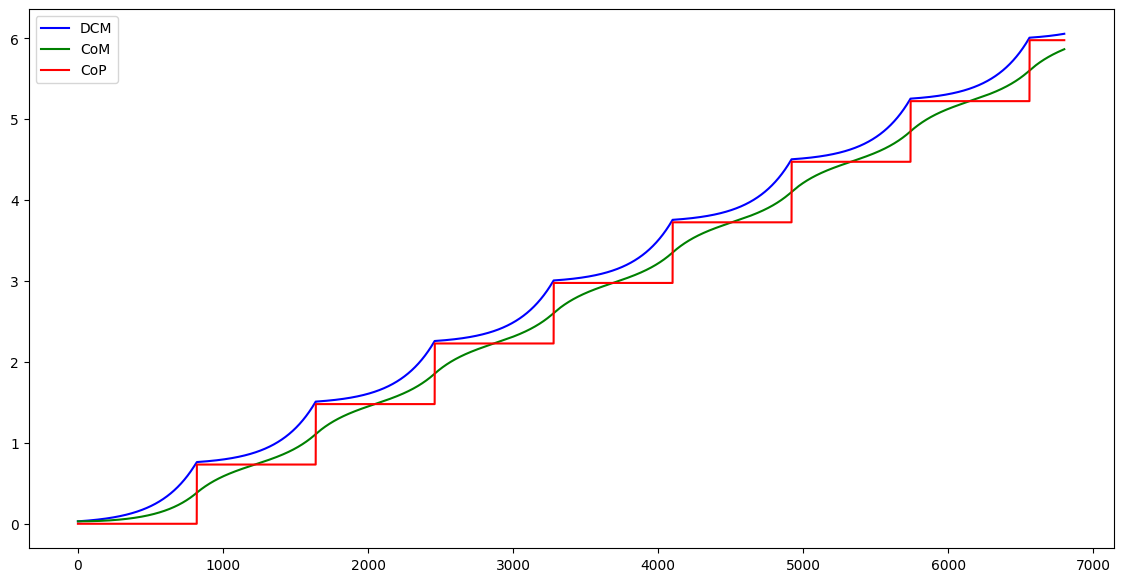

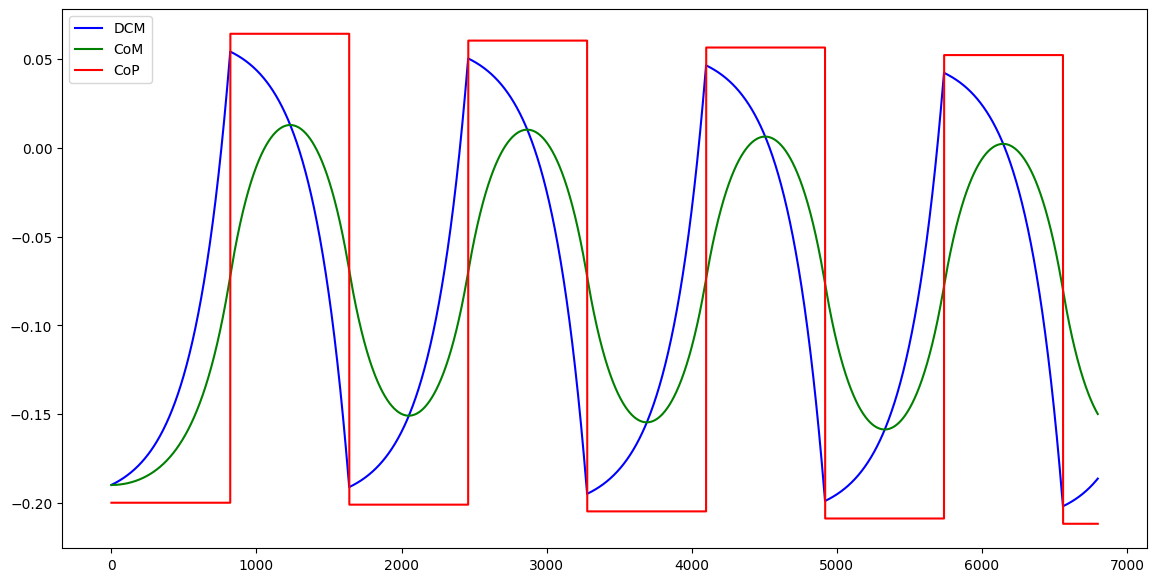

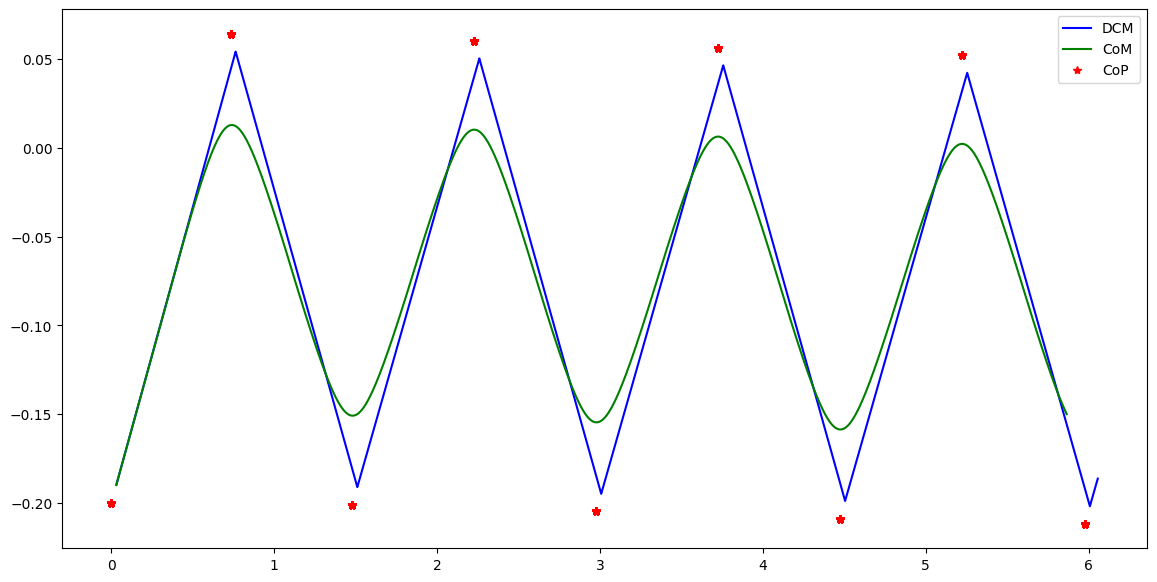

In [2]:
# TODO: First start to fill and complete the DCMTrajectoryGenerator based on equation (3) and (9) of the project description
# TODO: 首先填写 DCMTrajectoryGenerator.py 中的类

#then continue with the following part
NominalStepWidth=0.2#Nominal lateralDistanceOfFeet/2
NominalStepLength=0.4 # Nominal longitudinal distance between two sequential feet 
NominalStepDuration = 0.82# Nominal step duration 
CoMHeight=0.63 #constant center of mas height

dt_toy=0.001 # time step
DCMx=0.03 #initial DCM position in x direction
DCMy=-NominalStepWidth+0.01 #initial DCM position in y direction
CoPX=0.0 #initial CoP position in X direction
CoPY=-NominalStepWidth #initial CoP position in y direction

#create some lists for collecting data and plotting
DCMTrajectoryToy = list("")
CoMTrajectoryToy = list("")
CoPTrajectoryToy = list("")
ControlInputsToy = list("")

 
DCMGenerator = DCMTrajectoryGenerator(CoMHeight) # TODO: #We create an object of DCMTrajectoryGenerator Class 创建类的对象，创建参数为 CoMHeight 质心高度
DCMGenerator.initialDCM = np.array([DCMx ,DCMy])
DCMGenerator.timeStep = dt_toy
DCMGenerator.CoM = np.array([DCMx ,DCMy])

stepNumber=0
sign=1 #for switching between right and left leg, could +1 for left foot in swing and or -1 if right foot is in swing
internalStep=0.0

deltaStepDurationMin= 0.3 # we substract this value from nominal step duration to find lower boundry of step duration constraint
deltaStepDurationMax= 1.3 # we add this value to nominal step duration to find upper boundry of step duration constraint

for iter in range(6800):
    alphaCoPX = 1.0
    alphaCoPY = 1.0
    alphaSigma = 1.0
    alphaOffsetX = 1000
    alphaOffsetY = 1000
    
    #CoP Nominal
    CoPNoMX = NominalStepLength + CoPX #CoPX is added here to add previous step position to the nominal step length
    CoPNoMY = sign*NominalStepWidth  #sign parameters switches between right and left foot
    
    OffsetNoMX = 0.03 #nominal DCM x offset
    OffsetNoMY = -1*sign*0.01 #nominal DCM  y offset
    SigmaNoM =  np.exp(DCMGenerator.omega * NominalStepDuration) # TODO: #nominal sigma (function of NominalStepDuration) σ = exp(ωT) ?????????

    #make a boundry limit for the next step position and duration 
    CoPTMaxX = CoPNoMX+0.4 #next step position maximum constraits for x
    CoPTMaxY = CoPNoMY+0.4 #next step position maximum constraits for y
    
    CoPTMinX = CoPNoMX-0.4 #next step position minimum constrait for x
    CoPTMinY = CoPNoMY-0.4 #next step position minimum constrait for y
    
    SigmaMin =  np.exp(DCMGenerator.omega * (NominalStepDuration - deltaStepDurationMin)) # TODO: use NominalStepDuration and deltaStepDurationMin  ?????????
    SigmaMax =  np.exp(DCMGenerator.omega * (NominalStepDuration + deltaStepDurationMax)) # TODO: use NominalStepDuration and deltaStepDurationMax  ?????????
    
    # Initial Conditions
    CopXInit = CoPX
    DCMXInit = DCMx
    CopYInit = CoPY
    DCMYInit = DCMy
    DCMGenerator.CoP = np.array([CoPX ,CoPY]) #update the initial CoP position in the DCMTrajectoryGenerator
    
    
    #make Hessian, Gradient and Constraints matrix of QP based on equations 13,14,15 and 16, 
    #you can expand these equations to find the follwoing matrices 
    P = np.array([[2*alphaCoPX,0,0,0,0],
                  [0,2*alphaCoPY,0,0,0],
                  [0,0,2*alphaSigma,0,0],
                  [0,0,0,2*alphaOffsetX,0],
                  [0,0,0,0,2*alphaOffsetY]]) # TODO: use equation 14 and 16 to find the P and Q
    q = np.array([[-2*alphaCoPX*CoPNoMX],
                  [-2*alphaCoPY*CoPNoMY],
                  [-2*alphaSigma*SigmaNoM],
                  [-2*alphaOffsetX*OffsetNoMX],
                  [-2*alphaOffsetY*OffsetNoMY]]) # TODO: use equation 14 and 16 to find the P and Q
    
    G = np.array([[1,0,0,0,0],
                  [0,1,0,0,0],
                  [-1,0,0,0,0],
                  [0,-1,0,0,0],
                  [0,0,1,0,0],
                  [0,0,-1,0,0]]) # TODO: use equation 15 and 16 to find the G and h 
    h = np.array([[+CoPTMaxX],
                  [+CoPTMaxY],
                  [-CoPTMinX],
                  [-CoPTMinY],
                  [+SigmaMax],
                  [-SigmaMin]]) # TODO: use equation 15 and 16 to find the G and h
    
    A = np.array([[1,0,CopXInit-DCMXInit,1,0],
                  [0,1,CopYInit-DCMYInit,0,1]]) # TODO: use equation 13 and 16 to find the A and b 
    b = np.array([[CopXInit],
                  [CopYInit]])                  # TODO: use equation 13 and 16 to find the A and b 
    
    #solve QP problem U is the vector of optimized parameters
    U = solve_qp(P, q, G, h, A, b, solver="osqp")

    stepDuration =  np.log(U[2])/DCMGenerator.omega #TODO: find the step duration based on the the optimized sigma (use Log function to find step duration)
    
    # 这里的 DCM 二维数据会被添加到 画图队列里面 
    DesiredDCM = DCMGenerator.getDCMTrajectory(dt_toy)  #get the desired DCM for the next time-step 
    DesiredCoM = DCMGenerator.getCoM() #get the desired CoM for the next time-step 
         
        
    DCMGenerator.initialDCM = np.array([DesiredDCM[0] ,DesiredDCM[1]])#set the current DCM position ad next initial dcm position 
    
    DCMTrajectoryToy.append(DesiredDCM)
    CoMTrajectoryToy.append(DesiredCoM)
    CoPTrajectoryToy.append(np.array([CoPX,CoPY]))
    ControlInputsToy.append(U)
    
    internalStep = internalStep+1 #is used for resetting the step parameters
    
    #resetting step parameters when step duration is finished
    if(dt_toy*internalStep>stepDuration):
        stepNumber=stepNumber+1
        internalStep=0
        DCMGenerator.CoP= np.array([U[0] ,U[1]])
        sign=sign*-1 #0000FF 左右脚的交替
    
        CoPX =U[0]
        CoPY =U[1]

        DCMx =DesiredDCM[0]
        DCMy =DesiredDCM[1]
        

# TODO: uncomment to plot     
# 显示 X 方向    
figg, (ax) = plt.subplots(figsize=(14, 7))
ax.plot(np.array(DCMTrajectoryToy)[:, 0], 'b', label="DCM")
ax.plot(np.array(CoMTrajectoryToy)[:, 0], 'g', label="CoM")
ax.plot(np.array(CoPTrajectoryToy)[:, 0], 'r', label="CoP")
ax.legend()  # 添加这一行来显示图例
plt.show() 

# 显示 Y 方向
figg1, (ax1) = plt.subplots(figsize=(14, 7))
ax1.plot(np.array(DCMTrajectoryToy)[:, 1], 'b', label="DCM")
ax1.plot(np.array(CoMTrajectoryToy)[:, 1], 'g', label="CoM")
ax1.plot(np.array(CoPTrajectoryToy)[:, 1], 'r', label="CoP")
ax1.legend()  # 添加这一行来显示图例
plt.show() 

figg2, (ax2) = plt.subplots(figsize=(14, 7))
ax2.plot(np.array(DCMTrajectoryToy)[:, 0], np.array(DCMTrajectoryToy)[:, 1], 'b', label="DCM")
ax2.plot(np.array(CoMTrajectoryToy)[:, 0], np.array(CoMTrajectoryToy)[:, 1], 'g', label="CoM")
ax2.plot(np.array(CoPTrajectoryToy)[:, 0], np.array(CoPTrajectoryToy)[:, 1], '*r', label="CoP")
ax2.legend()  # 添加这一行来显示图例
plt.show() 
